# Training Military Vehicle Detection Model with YOLO-NAS

#### Importing Necessary Libraries and Modules

In [13]:
import os
import cv2
import torch
import time
import re
import matplotlib.pyplot as plt

from roboflow import Roboflow
from IPython.display import clear_output
from super_gradients.training import models, Trainer
from super_gradients.training import dataloaders
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

#### Setting Up the Device for Training

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU instead.")

I1230 18:51:46.581850 139786570883712 env_sanity_check.py:112] torch==2.1.0a0+32f93b1 does not satisfy requirement torch>=1.9.0
I1230 18:51:46.583803 139786570883712 env_sanity_check.py:112] torchvision==0.16.0a0 does not satisfy requirement torchvision>=0.10.0
I1230 18:51:46.585134 139786570883712 env_sanity_check.py:112] pyparsing==2.4.7 does not satisfy requirement pyparsing==2.4.5


Using GPU: NVIDIA RTX A5000


### Download the dataset using Roboflow API

In [5]:
# rf = Roboflow(api_key="<your-api-key>")  # Replace <your-api-key> with your actual Roboflow API key.
# project = rf.workspace("vgtu-n8zmy").project("military-vehicle")
# dataset = project.version(6).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.


Extracting Dataset Version Zip to military-vehicle-6 in yolov8:: 100%|██████████| 5216/5216 [00:15<00:00, 344.36it/s] 


### Download the dataset from Google Drive

In [ ]:
# !gdown 'https://drive.google.com/uc?id=1MYhcTICu2Zz-T7wqBfWsaR57j8TingvY'
# !unzip military-vehicle-6.zip
# !rm -rf military-vehicle-6.zip

# clear_output()

## Image Enhancement for Improved Model Training

The `ImageEnhancer` class is defined to handle the enhancement of images in the dataset. Enhancing images is an essential process for training a military vehicle detection model. It can notably improve the model's capability in detecting and recognizing features within the images.
### Usage

- An instance of `ImageEnhancer` is instantiated with the path to the training images (`'military-vehicle-6/train/images'`).
- The `process_images` method is called on this instance to apply enhancements to all images in the specified directory.

Image enhancement like this ensures that the training process benefits from clearer, higher-contrast images, potentially leading to improved detection capabilities of military vehicles. This preprocessing step is pivotal in preparing the dataset for effective training.


In [6]:
class ImageEnhancer:
    """
    A class for enhancing images in a given dataset directory. This class is designed 
    to improve the quality of images by applying image processing techniques, 
    specifically tailored for preparing images for a military vehicle detection model.

    Attributes:
        train_path (str): The file path to the training images.

    Methods:
        enhance_image(image): Enhances an individual image using color space conversion 
                              and CLAHE (Contrast Limited Adaptive Histogram Equalization).
        process_images(): Processes and enhances all images in the specified training path.
    """
    
    def __init__(self, train_path):
        """
        Initializes the ImageEnhancer with a specified training path.

        Args:
            train_path (str): The file path to the training images.
        """
        self.train_path = train_path

    def enhance_image(self, image):
        """
        Enhances an image by converting it to LAB color space and applying CLAHE to 
        the L channel. This method is used to improve the contrast and quality of 
        the image, which is beneficial for the training of object detection models.

        Args:
            image (numpy.ndarray): An image in BGR format to be enhanced.

        Returns:
            numpy.ndarray: The enhanced image in BGR format.
        """
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_channel_clahe = clahe.apply(l_channel)

        lab_enhanced = cv2.merge((l_channel_clahe, a_channel, b_channel))
        enhanced_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

        return enhanced_image

    def process_images(self):
        """
        Processes and enhances all '.jpg' images in the training path set during 
        initialization. Each image is read, enhanced, and overwritten in the same 
        directory with the enhanced version.
        """
        train_files = os.listdir(self.train_path)
        for file_name in train_files:
            if file_name.endswith(".jpg"):
                file_path = os.path.join(self.train_path, file_name)
                image = cv2.imread(file_path)
                enhanced_image = self.enhance_image(image)
                cv2.imwrite(file_path, enhanced_image)


train_path = 'military-vehicle-6/train/images'
enhancer = ImageEnhancer(train_path)
enhancer.process_images()

## Configuring the Trainer

At the core of the training procedure using SuperGradient library is the **`Trainer`** class. This crucial component is in charge of overseeing the training sessions, conducting evaluations, and managing checkpoint operations. Initiation of this process involves defining two essential parameters:   

-  **`ckpt_root_dir`**: This parameter designates the root directory where the outputs from all experiments are stored. It is a central location for all training-related data, including models, logs, and results.

- **`experiment_name`**: This is a unique identifier for the experiment. It organizes and saves checkpoints, logs under this specific name, aiding in tracking and managing your training endeavors.

Setting up these parameters ensures an organized, efficient framework for training and evaluating models within the SuperGradients platform..

In [4]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='detection', ckpt_root_dir=CHECKPOINT_DIR)

### Organizing Dataset Parameters for Training

Proper configuration of dataset parameters is a critical step in the training process using SuperGradien libraryts. This involves setting up a Python dictionary that clearly outlines the structure and components of your dataset:

- **Root Dataset Directory**: Assign the path to the directory where your dataset is located. For your dataset, this is `'military-vehicle-6'`, which is the overarching folder containing all data files.

- **Paths for Dataset Segments**: Paths for the various sections of your dataset within this dictionary:
  - **Training Data**: Paths to the images (`'train/images'`) and labels (`'train/labels'`) used for training.
  - **Validation Data**: Paths for validation images (`'valid/images'`) and labels (`'valid/labels'`).
  - **Testing Data**: Paths for test images (`'test/images'`) and labels (`'test/labels'`).

- **Class Identification**: List the classes your model is intended to detect. In this case, it includes a single class: `'military_vehicle'`.

The dataset parameters for this project are organised the following way:


In [5]:
dataset_params = {
    'data_dir':'military-vehicle-6',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['military_vehicle']
}

### Initializing Dataloaders

SuperGradients streamlines the creation of data loaders, which are crucial for efficiently processing and supplying data to the model during training, validation, and testing stages. The configuration for these data loaders in this project is outlined below:

- **Training Data Loader Setup**: 
  Utilizing `coco_detection_yolo_format_train`, the training data loader is established. Parameters for the dataset (`dataset_params`) include paths to training images, labels, and the classes being detected. The `dataloader_params` are configured with a `batch_size` of 8 and `num_workers` set to 0.

- **Validation Data Loader Configuration**: 
  The validation data loader is created using `coco_detection_yolo_format_val`. It mirrors the training setup in `dataset_params`, specifying paths for validation images, labels, and classes. The loader operates with the same `batch_size` of 8 and `num_workers` set to 0.

- **Testing Data Loader Arrangement**: 
  For testing, the `coco_detection_yolo_format_val` function is again employed. The `dataset_params` for this phase include paths for test images, labels, and classes. The `dataloader_params` differ slightly, with a `batch_size` of 1 and `num_workers` as 0, suited for in-depth testing.

The `clear_output()` function is invoked subsequently to tidy up the notebook's output, ensuring the workspace remains clear and well-organized. This setup guarantees that the data is aptly prepared and loaded for each stage of the model's training and evaluation.


In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':0
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':0
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':1,
        'num_workers':0
    }
)

clear_output()

## Managing Annotations and Applying Transforms

SuperGradients data loaders are adept at handling annotations in the dataset. They automatically detect and alert about any non-standard annotation formats, ensuring data consistency and compatibility for the training process.

Additionally, SuperGradients integrates automatic data transformations. These transformations play a key role in data augmentation, enhancing the dataset's variety and improving the model's ability to generalodection model.


#### Inspecting Dataset Transforms

In [7]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

Indexing dataset annotations: 100%|██████████| 112/112 [00:00<00:00, 570.45it/s]


#### Visualizing Augmented Data

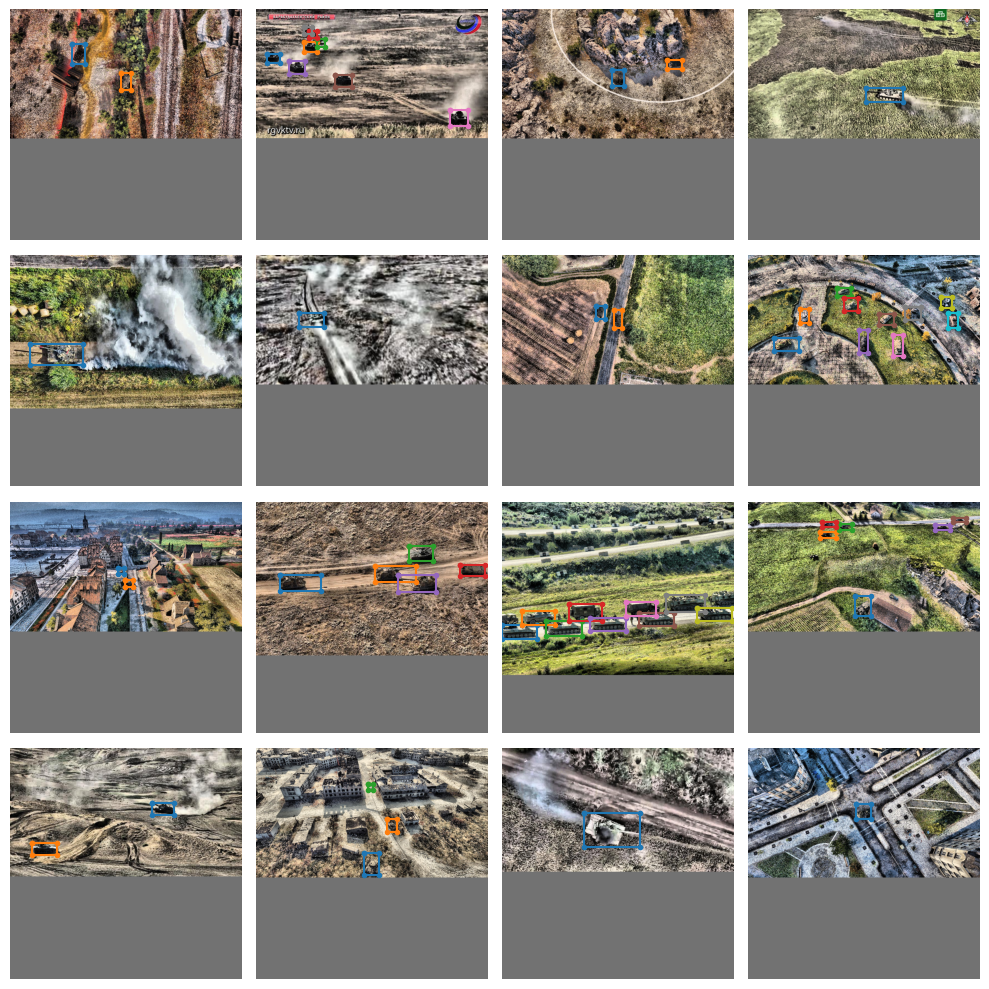

In [8]:
val_data.dataset.plot()

## Selection and Configuration of the YOLO-NAS Model

The project employs a specific YOLO-NAS model variant, `yolo_nas_l`. The process of setting up this model for the military vehicle detection task involves several important configurations:

- **Model Choice**: The selection of the `yolo_nas_l` variant from the YOLO-NAS family of models is strategic, catering to the specific needs of the military vehicle detection task.

- **Class Configuration**: The model is tailored to the number of classes in the dataset. This is achieved by setting the `num_classes` parameter to the length of the `classes` array in `dataset_params`, in this case its 1.

- **Utilising Pretrained Weights**: Initialising the model with `pretrained_weights` set to `"coco"` leverages the robust foundation provided by weights trained on the extensive COCO dataset. This step enhances the starting point for the model's training process.

- **Device Assignment**: The model is assigned to the designated computing device (GPU or CPU) using `.to(device)`, optimising its performance during training by utilising available hardware resources eficiently.


In [9]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   ).to(device)

## Configuration of Training Parameters and Metrics

Setting up the training parameters correctly is essential in the SuperGradients environment to guide the training process effectively and impact the model's performance. This overview provides insights into the key training parameters and advanced features:

#### Training Parameters (`train_params` Dictionary)

- **`silent_mode`**: Set to `False` for detailed output during training.
- **`average_best_models`**: Enhances performance by averaging the best models.
- **`initial_lr`**: Sets the learning rate initially at `1e-4`.
- **`cosine_final_lr_ratio`**: Adjusts the final learning rate as a fraction of the initial rate.
- **`optimizer`**: The `Adam` optimizer is specified for use.
- **`max_epochs`**: Limits training to 50 epochs.
- **`mixed_precision`**: Enables mixed precision training, combining different numerical precisions for efficient and fast training without losing accuracy.
- **`loss`**: `PPYoloELoss` is set as the loss function with specific parameters like `num_classes` and `reg_max`.

#### Validation Metrics (`valid_metrics_list`)

- **`DetectionMetrics_050`**: Includes `score_thres` for setting the detection scoring threshold, focusing on high-confidence predictions. It also specifies `top_k_predictions`, `num_cls`, and integrates `PPYoloEPostPredictionCallback` for refined post-prediction processing.

- **`metric_to_watch`**: The primary metric to monitor is set as `'F1@0.50'`.

This setup ensures a well-optimised and effective training framework for the military vehicle detection model, concentrating on both training efficiency and detection accuracy.


In [10]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "initial_lr": 1e-4,
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
#     # TRAINING FOR 50 EPOCHS
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.5,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'F1@0.50'
}

## Launching the Training Process

With the model, training parameters, and data loaders all set up, it's time to begin the training of the military vehicle detection model. This phase is critical as it actualizes all the preparatory configurations and commences the development of the trained model.
The training is initiated with the `train` method of the `trainer` object, incorporating the following key components:

- **`model`**: The configured `yolo_nas_l` model, specifically prepared for military vehicle detection.
- **`training_params`**: The comprehensive `train_params` dictionary, outlining all the training settings including the learning rate, optimizer, loss function, and more.
- **`train_loader`**: The `train_data` loader, which provides the training dataset in batches, including both the processed images and their annotations.
- **`valid_loader`**: The `val_data` loader for validation, offering a distinct dataset to assess the model's performance and its ability to generalise during the training.


In [16]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/detection/RUN_20231230_124449_544688/console_Dec30_12_44_49.txt


[2023-12-30 12:44:50] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            2274       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         284        (len(train_loader))
    - Gradient updates per epoch:   284        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0001 (66.91M parameters) WD: 0.0001, (66.91M parameters)

[2023-12-30 12:44:50] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Validating: 1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1105
│   ├── Ppyoloeloss/loss_iou = 0.7463
│   ├── Ppyoloeloss/loss_dfl = 0.5587
│   └── Ppyoloeloss/loss = 2.4155
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0959
    ├── Ppyoloeloss/loss_iou = 0.5939
    ├── Ppyoloeloss/loss_dfl = 0.4714
    ├── Ppyoloeloss/loss = 2.1612
    ├── Precision@0.50 = 0.7464
    ├── Recall@0.50 = 0.3667
    ├── Map@0.50 = 0.5155
    └── F1@0.50 = 0.4918



Validating epoch 1: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]
[2023-12-30 12:59:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 12:59:09] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.613573431968689


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9708
│   │   ├── Epoch N-1      = 1.1105 (↘ -0.1397)
│   │   └── Best until now = 1.1105 (↘ -0.1397)
│   ├── Ppyoloeloss/loss_iou = 0.6223
│   │   ├── Epoch N-1      = 0.7463 (↘ -0.124)
│   │   └── Best until now = 0.7463 (↘ -0.124)
│   ├── Ppyoloeloss/loss_dfl = 0.4811
│   │   ├── Epoch N-1      = 0.5587 (↘ -0.0776)
│   │   └── Best until now = 0.5587 (↘ -0.0776)
│   └── Ppyoloeloss/loss = 2.0742
│       ├── Epoch N-1      = 2.4155 (↘ -0.3413)
│       └── Best until now = 2.4155 (↘ -0.3413)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9583
    │   ├── Epoch N-1      = 1.0959 (↘ -0.1376)
    │   └── Best until now = 1.0959 (↘ -0.1376)
    ├── Ppyoloeloss/loss_iou = 0.5521
    │   ├── Epoch N-1      = 0.5939 (↘ -0.0418)
    │   └── Best until now = 0.5939 (↘ -0.0418)
    ├── Ppyoloeloss/loss_dfl = 0.4608
    │   ├── Epoch N-1      = 0.4714 (↘ -0.0106)
    │   └── Best until now = 0.4714 (↘ -0.0106)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9406
│   │   ├── Epoch N-1      = 0.9708 (↘ -0.0301)
│   │   └── Best until now = 0.9708 (↘ -0.0301)
│   ├── Ppyoloeloss/loss_iou = 0.5944
│   │   ├── Epoch N-1      = 0.6223 (↘ -0.0279)
│   │   └── Best until now = 0.6223 (↘ -0.0279)
│   ├── Ppyoloeloss/loss_dfl = 0.4683
│   │   ├── Epoch N-1      = 0.4811 (↘ -0.0128)
│   │   └── Best until now = 0.4811 (↘ -0.0128)
│   └── Ppyoloeloss/loss = 2.0033
│       ├── Epoch N-1      = 2.0742 (↘ -0.0708)
│       └── Best until now = 2.0742 (↘ -0.0708)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0584
    │   ├── Epoch N-1      = 0.9583 (↗ 0.1001)
    │   └── Best until now = 0.9583 (↗ 0.1001)
    ├── Ppyoloeloss/loss_iou = 0.5985
    │   ├── Epoch N-1      = 0.5521 (↗ 0.0464)
    │   └── Best until now = 0.5521 (↗ 0.0464)
    ├── Ppyoloeloss/loss_dfl = 0.4901
    │   ├── Epoch N-1      = 0.4608 (↗ 0.0293)
    │   └── Best until now = 0.4608 (↗ 0.0293)
    ├── Ppyoloeloss/loss = 2

Validating epoch 3: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]
[2023-12-30 13:13:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 13:13:23] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.641048789024353


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9187
│   │   ├── Epoch N-1      = 0.9406 (↘ -0.0219)
│   │   └── Best until now = 0.9406 (↘ -0.0219)
│   ├── Ppyoloeloss/loss_iou = 0.5791
│   │   ├── Epoch N-1      = 0.5944 (↘ -0.0153)
│   │   └── Best until now = 0.5944 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_dfl = 0.456
│   │   ├── Epoch N-1      = 0.4683 (↘ -0.0123)
│   │   └── Best until now = 0.4683 (↘ -0.0123)
│   └── Ppyoloeloss/loss = 1.9538
│       ├── Epoch N-1      = 2.0033 (↘ -0.0495)
│       └── Best until now = 2.0033 (↘ -0.0495)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9532
    │   ├── Epoch N-1      = 1.0584 (↘ -0.1052)
    │   └── Best until now = 0.9583 (↘ -0.0051)
    ├── Ppyoloeloss/loss_iou = 0.5702
    │   ├── Epoch N-1      = 0.5985 (↘ -0.0284)
    │   └── Best until now = 0.5521 (↗ 0.018)
    ├── Ppyoloeloss/loss_dfl = 0.4633
    │   ├── Epoch N-1      = 0.4901 (↘ -0.0268)
    │   └── Best until now = 0.4608 (↗ 0.0025)
    ├── Ppyoloeloss/loss =

Validating epoch 4: 100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9039
│   │   ├── Epoch N-1      = 0.9187 (↘ -0.0148)
│   │   └── Best until now = 0.9187 (↘ -0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.5702
│   │   ├── Epoch N-1      = 0.5791 (↘ -0.0089)
│   │   └── Best until now = 0.5791 (↘ -0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.4529
│   │   ├── Epoch N-1      = 0.456  (↘ -0.0031)
│   │   └── Best until now = 0.456  (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.927
│       ├── Epoch N-1      = 1.9538 (↘ -0.0269)
│       └── Best until now = 1.9538 (↘ -0.0269)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2365
    │   ├── Epoch N-1      = 0.9532 (↗ 0.2833)
    │   └── Best until now = 0.9532 (↗ 0.2833)
    ├── Ppyoloeloss/loss_iou = 0.5527
    │   ├── Epoch N-1      = 0.5702 (↘ -0.0175)
    │   └── Best until now = 0.5521 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.4628
    │   ├── Epoch N-1      = 0.4633 (↘ -0.0005)
    │   └── Best until now = 0.4608 (↗ 0.002)
    ├── Ppyoloeloss/loss = 2

Validating epoch 5: 100%|██████████| 27/27 [00:09<00:00,  2.99it/s]
[2023-12-30 13:27:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 13:27:38] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.660305380821228


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8937
│   │   ├── Epoch N-1      = 0.9039 (↘ -0.0102)
│   │   └── Best until now = 0.9039 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.5526
│   │   ├── Epoch N-1      = 0.5702 (↘ -0.0176)
│   │   └── Best until now = 0.5702 (↘ -0.0176)
│   ├── Ppyoloeloss/loss_dfl = 0.4455
│   │   ├── Epoch N-1      = 0.4529 (↘ -0.0074)
│   │   └── Best until now = 0.4529 (↘ -0.0074)
│   └── Ppyoloeloss/loss = 1.8918
│       ├── Epoch N-1      = 1.927  (↘ -0.0352)
│       └── Best until now = 1.927  (↘ -0.0352)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0074
    │   ├── Epoch N-1      = 1.2365 (↘ -0.2292)
    │   └── Best until now = 0.9532 (↗ 0.0542)
    ├── Ppyoloeloss/loss_iou = 0.5485
    │   ├── Epoch N-1      = 0.5527 (↘ -0.0042)
    │   └── Best until now = 0.5521 (↘ -0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.4475
    │   ├── Epoch N-1      = 0.4628 (↘ -0.0153)
    │   └── Best until now = 0.4608 (↘ -0.0133)
    ├── Ppyoloeloss/los

Validating epoch 6: 100%|██████████| 27/27 [00:09<00:00,  3.00it/s]
[2023-12-30 13:34:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 13:34:50] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.6831955909729004


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8787
│   │   ├── Epoch N-1      = 0.8937 (↘ -0.0151)
│   │   └── Best until now = 0.8937 (↘ -0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.5433
│   │   ├── Epoch N-1      = 0.5526 (↘ -0.0093)
│   │   └── Best until now = 0.5526 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.441
│   │   ├── Epoch N-1      = 0.4455 (↘ -0.0045)
│   │   └── Best until now = 0.4455 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.8629
│       ├── Epoch N-1      = 1.8918 (↘ -0.0289)
│       └── Best until now = 1.8918 (↘ -0.0289)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0259
    │   ├── Epoch N-1      = 1.0074 (↗ 0.0186)
    │   └── Best until now = 0.9532 (↗ 0.0728)
    ├── Ppyoloeloss/loss_iou = 0.5404
    │   ├── Epoch N-1      = 0.5485 (↘ -0.0081)
    │   └── Best until now = 0.5485 (↘ -0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.4553
    │   ├── Epoch N-1      = 0.4475 (↗ 0.0078)
    │   └── Best until now = 0.4475 (↗ 0.0078)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8708
│   │   ├── Epoch N-1      = 0.8787 (↘ -0.0079)
│   │   └── Best until now = 0.8787 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.5409
│   │   ├── Epoch N-1      = 0.5433 (↘ -0.0024)
│   │   └── Best until now = 0.5433 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.4356
│   │   ├── Epoch N-1      = 0.441  (↘ -0.0054)
│   │   └── Best until now = 0.441  (↘ -0.0054)
│   └── Ppyoloeloss/loss = 1.8472
│       ├── Epoch N-1      = 1.8629 (↘ -0.0157)
│       └── Best until now = 1.8629 (↘ -0.0157)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9879
    │   ├── Epoch N-1      = 1.0259 (↘ -0.038)
    │   └── Best until now = 0.9532 (↗ 0.0348)
    ├── Ppyoloeloss/loss_iou = 0.5231
    │   ├── Epoch N-1      = 0.5404 (↘ -0.0173)
    │   └── Best until now = 0.5404 (↘ -0.0173)
    ├── Ppyoloeloss/loss_dfl = 0.4464
    │   ├── Epoch N-1      = 0.4553 (↘ -0.0088)
    │   └── Best until now = 0.4475 (↘ -0.0011)
    ├── Ppyoloeloss/loss

Validating epoch 8: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8559
│   │   ├── Epoch N-1      = 0.8708 (↘ -0.0149)
│   │   └── Best until now = 0.8708 (↘ -0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.5282
│   │   ├── Epoch N-1      = 0.5409 (↘ -0.0127)
│   │   └── Best until now = 0.5409 (↘ -0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.4292
│   │   ├── Epoch N-1      = 0.4356 (↘ -0.0064)
│   │   └── Best until now = 0.4356 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.8133
│       ├── Epoch N-1      = 1.8472 (↘ -0.0339)
│       └── Best until now = 1.8472 (↘ -0.0339)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.052
    │   ├── Epoch N-1      = 0.9879 (↗ 0.0641)
    │   └── Best until now = 0.9532 (↗ 0.0988)
    ├── Ppyoloeloss/loss_iou = 0.515
    │   ├── Epoch N-1      = 0.5231 (↘ -0.0082)
    │   └── Best until now = 0.5231 (↘ -0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.4332
    │   ├── Epoch N-1      = 0.4464 (↘ -0.0133)
    │   └── Best until now = 0.4464 (↘ -0.0133)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8496
│   │   ├── Epoch N-1      = 0.8559 (↘ -0.0064)
│   │   └── Best until now = 0.8559 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.5184
│   │   ├── Epoch N-1      = 0.5282 (↘ -0.0098)
│   │   └── Best until now = 0.5282 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.4246
│   │   ├── Epoch N-1      = 0.4292 (↘ -0.0046)
│   │   └── Best until now = 0.4292 (↘ -0.0046)
│   └── Ppyoloeloss/loss = 1.7926
│       ├── Epoch N-1      = 1.8133 (↘ -0.0207)
│       └── Best until now = 1.8133 (↘ -0.0207)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1744
    │   ├── Epoch N-1      = 1.052  (↗ 0.1224)
    │   └── Best until now = 0.9532 (↗ 0.2212)
    ├── Ppyoloeloss/loss_iou = 0.5277
    │   ├── Epoch N-1      = 0.515  (↗ 0.0127)
    │   └── Best until now = 0.515  (↗ 0.0127)
    ├── Ppyoloeloss/loss_dfl = 0.4459
    │   ├── Epoch N-1      = 0.4332 (↗ 0.0128)
    │   └── Best until now = 0.4332 (↗ 0.0128)
    ├── Ppyoloeloss/loss = 2

Validating epoch 10: 100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8496
│   │   ├── Epoch N-1      = 0.8496 (↗ 0.0)
│   │   └── Best until now = 0.8496 (↗ 0.0)
│   ├── Ppyoloeloss/loss_iou = 0.5166
│   │   ├── Epoch N-1      = 0.5184 (↘ -0.0018)
│   │   └── Best until now = 0.5184 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.4273
│   │   ├── Epoch N-1      = 0.4246 (↗ 0.0027)
│   │   └── Best until now = 0.4246 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.7935
│       ├── Epoch N-1      = 1.7926 (↗ 0.0008)
│       └── Best until now = 1.7926 (↗ 0.0008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0378
    │   ├── Epoch N-1      = 1.1744 (↘ -0.1366)
    │   └── Best until now = 0.9532 (↗ 0.0846)
    ├── Ppyoloeloss/loss_iou = 0.5465
    │   ├── Epoch N-1      = 0.5277 (↗ 0.0188)
    │   └── Best until now = 0.515  (↗ 0.0315)
    ├── Ppyoloeloss/loss_dfl = 0.4635
    │   ├── Epoch N-1      = 0.4459 (↗ 0.0176)
    │   └── Best until now = 0.4332 (↗ 0.0304)
    ├── Ppyoloeloss/loss = 2.0478
    

Validating epoch 11: 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8405
│   │   ├── Epoch N-1      = 0.8496 (↘ -0.0091)
│   │   └── Best until now = 0.8496 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_iou = 0.5141
│   │   ├── Epoch N-1      = 0.5166 (↘ -0.0024)
│   │   └── Best until now = 0.5166 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.425
│   │   ├── Epoch N-1      = 0.4273 (↘ -0.0023)
│   │   └── Best until now = 0.4246 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.7796
│       ├── Epoch N-1      = 1.7935 (↘ -0.0139)
│       └── Best until now = 1.7926 (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0202
    │   ├── Epoch N-1      = 1.0378 (↘ -0.0175)
    │   └── Best until now = 0.9532 (↗ 0.0671)
    ├── Ppyoloeloss/loss_iou = 0.5231
    │   ├── Epoch N-1      = 0.5465 (↘ -0.0234)
    │   └── Best until now = 0.515  (↗ 0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.4395
    │   ├── Epoch N-1      = 0.4635 (↘ -0.0241)
    │   └── Best until now = 0.4332 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 

Validating epoch 12: 100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8437
│   │   ├── Epoch N-1      = 0.8405 (↗ 0.0032)
│   │   └── Best until now = 0.8405 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.5093
│   │   ├── Epoch N-1      = 0.5141 (↘ -0.0049)
│   │   └── Best until now = 0.5141 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.4218
│   │   ├── Epoch N-1      = 0.425  (↘ -0.0032)
│   │   └── Best until now = 0.4246 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.7747
│       ├── Epoch N-1      = 1.7796 (↘ -0.0049)
│       └── Best until now = 1.7796 (↘ -0.0049)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.055
    │   ├── Epoch N-1      = 1.0202 (↗ 0.0347)
    │   └── Best until now = 0.9532 (↗ 0.1018)
    ├── Ppyoloeloss/loss_iou = 0.53
    │   ├── Epoch N-1      = 0.5231 (↗ 0.0069)
    │   └── Best until now = 0.515  (↗ 0.015)
    ├── Ppyoloeloss/loss_dfl = 0.4376
    │   ├── Epoch N-1      = 0.4395 (↘ -0.0018)
    │   └── Best until now = 0.4332 (↗ 0.0045)
    ├── Ppyoloeloss/loss = 2.022

Validating epoch 13: 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8363
│   │   ├── Epoch N-1      = 0.8437 (↘ -0.0074)
│   │   └── Best until now = 0.8405 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.5034
│   │   ├── Epoch N-1      = 0.5093 (↘ -0.0059)
│   │   └── Best until now = 0.5093 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.4207
│   │   ├── Epoch N-1      = 0.4218 (↘ -0.001)
│   │   └── Best until now = 0.4218 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.7604
│       ├── Epoch N-1      = 1.7747 (↘ -0.0143)
│       └── Best until now = 1.7747 (↘ -0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.977
    │   ├── Epoch N-1      = 1.055  (↘ -0.078)
    │   └── Best until now = 0.9532 (↗ 0.0238)
    ├── Ppyoloeloss/loss_iou = 0.5099
    │   ├── Epoch N-1      = 0.53   (↘ -0.0201)
    │   └── Best until now = 0.515  (↘ -0.005)
    ├── Ppyoloeloss/loss_dfl = 0.4297
    │   ├── Epoch N-1      = 0.4376 (↘ -0.0079)
    │   └── Best until now = 0.4332 (↘ -0.0035)
    ├── Ppyoloeloss/loss = 

Validating epoch 14: 100%|██████████| 27/27 [00:08<00:00,  3.09it/s]
[2023-12-30 14:32:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 14:32:57] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.6888763308525085


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8313
│   │   ├── Epoch N-1      = 0.8363 (↘ -0.005)
│   │   └── Best until now = 0.8363 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.5081
│   │   ├── Epoch N-1      = 0.5034 (↗ 0.0047)
│   │   └── Best until now = 0.5034 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.4188
│   │   ├── Epoch N-1      = 0.4207 (↘ -0.002)
│   │   └── Best until now = 0.4207 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.7582
│       ├── Epoch N-1      = 1.7604 (↘ -0.0022)
│       └── Best until now = 1.7604 (↘ -0.0022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0036
    │   ├── Epoch N-1      = 0.977  (↗ 0.0266)
    │   └── Best until now = 0.9532 (↗ 0.0504)
    ├── Ppyoloeloss/loss_iou = 0.5201
    │   ├── Epoch N-1      = 0.5099 (↗ 0.0102)
    │   └── Best until now = 0.5099 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.4306
    │   ├── Epoch N-1      = 0.4297 (↗ 0.0009)
    │   └── Best until now = 0.4297 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 1.9543

Validating epoch 15: 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8264
│   │   ├── Epoch N-1      = 0.8313 (↘ -0.0049)
│   │   └── Best until now = 0.8313 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.4971
│   │   ├── Epoch N-1      = 0.5081 (↘ -0.011)
│   │   └── Best until now = 0.5034 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.4171
│   │   ├── Epoch N-1      = 0.4188 (↘ -0.0016)
│   │   └── Best until now = 0.4188 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.7407
│       ├── Epoch N-1      = 1.7582 (↘ -0.0175)
│       └── Best until now = 1.7582 (↘ -0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9903
    │   ├── Epoch N-1      = 1.0036 (↘ -0.0133)
    │   └── Best until now = 0.9532 (↗ 0.0371)
    ├── Ppyoloeloss/loss_iou = 0.5279
    │   ├── Epoch N-1      = 0.5201 (↗ 0.0078)
    │   └── Best until now = 0.5099 (↗ 0.018)
    ├── Ppyoloeloss/loss_dfl = 0.4486
    │   ├── Epoch N-1      = 0.4306 (↗ 0.018)
    │   └── Best until now = 0.4297 (↗ 0.0189)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 16: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8248
│   │   ├── Epoch N-1      = 0.8264 (↘ -0.0017)
│   │   └── Best until now = 0.8264 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4967
│   │   ├── Epoch N-1      = 0.4971 (↘ -0.0004)
│   │   └── Best until now = 0.4971 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.415
│   │   ├── Epoch N-1      = 0.4171 (↘ -0.0022)
│   │   └── Best until now = 0.4171 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.7364
│       ├── Epoch N-1      = 1.7407 (↘ -0.0042)
│       └── Best until now = 1.7407 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0366
    │   ├── Epoch N-1      = 0.9903 (↗ 0.0462)
    │   └── Best until now = 0.9532 (↗ 0.0834)
    ├── Ppyoloeloss/loss_iou = 0.4924
    │   ├── Epoch N-1      = 0.5279 (↘ -0.0355)
    │   └── Best until now = 0.5099 (↘ -0.0175)
    ├── Ppyoloeloss/loss_dfl = 0.4246
    │   ├── Epoch N-1      = 0.4486 (↘ -0.024)
    │   └── Best until now = 0.4297 (↘ -0.0051)
    ├── Ppyoloeloss/loss 

Validating epoch 17: 100%|██████████| 27/27 [00:08<00:00,  3.05it/s]
[2023-12-30 14:54:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 14:54:51] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.7153558135032654


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8153
│   │   ├── Epoch N-1      = 0.8248 (↘ -0.0095)
│   │   └── Best until now = 0.8248 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.4911
│   │   ├── Epoch N-1      = 0.4967 (↘ -0.0056)
│   │   └── Best until now = 0.4967 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.4104
│   │   ├── Epoch N-1      = 0.415  (↘ -0.0045)
│   │   └── Best until now = 0.415  (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.7168
│       ├── Epoch N-1      = 1.7364 (↘ -0.0196)
│       └── Best until now = 1.7364 (↘ -0.0196)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8951
    │   ├── Epoch N-1      = 1.0366 (↘ -0.1414)
    │   └── Best until now = 0.9532 (↘ -0.058)
    ├── Ppyoloeloss/loss_iou = 0.4985
    │   ├── Epoch N-1      = 0.4924 (↗ 0.0061)
    │   └── Best until now = 0.4924 (↗ 0.0061)
    ├── Ppyoloeloss/loss_dfl = 0.4239
    │   ├── Epoch N-1      = 0.4246 (↘ -0.0007)
    │   └── Best until now = 0.4246 (↘ -0.0007)
    ├── Ppyoloeloss/loss

Validating epoch 18: 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8125
│   │   ├── Epoch N-1      = 0.8153 (↘ -0.0028)
│   │   └── Best until now = 0.8153 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4894
│   │   ├── Epoch N-1      = 0.4911 (↘ -0.0017)
│   │   └── Best until now = 0.4911 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.4121
│   │   ├── Epoch N-1      = 0.4104 (↗ 0.0017)
│   │   └── Best until now = 0.4104 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 1.7139
│       ├── Epoch N-1      = 1.7168 (↘ -0.0029)
│       └── Best until now = 1.7168 (↘ -0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9525
    │   ├── Epoch N-1      = 0.8951 (↗ 0.0574)
    │   └── Best until now = 0.8951 (↗ 0.0574)
    ├── Ppyoloeloss/loss_iou = 0.511
    │   ├── Epoch N-1      = 0.4985 (↗ 0.0125)
    │   └── Best until now = 0.4924 (↗ 0.0186)
    ├── Ppyoloeloss/loss_dfl = 0.4354
    │   ├── Epoch N-1      = 0.4239 (↗ 0.0115)
    │   └── Best until now = 0.4239 (↗ 0.0115)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 19: 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8074
│   │   ├── Epoch N-1      = 0.8125 (↘ -0.0051)
│   │   └── Best until now = 0.8125 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.4817
│   │   ├── Epoch N-1      = 0.4894 (↘ -0.0077)
│   │   └── Best until now = 0.4894 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.4105
│   │   ├── Epoch N-1      = 0.4121 (↘ -0.0016)
│   │   └── Best until now = 0.4104 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.6995
│       ├── Epoch N-1      = 1.7139 (↘ -0.0144)
│       └── Best until now = 1.7139 (↘ -0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.008
    │   ├── Epoch N-1      = 0.9525 (↗ 0.0555)
    │   └── Best until now = 0.8951 (↗ 0.1128)
    ├── Ppyoloeloss/loss_iou = 0.5038
    │   ├── Epoch N-1      = 0.511  (↘ -0.0072)
    │   └── Best until now = 0.4924 (↗ 0.0114)
    ├── Ppyoloeloss/loss_dfl = 0.4321
    │   ├── Epoch N-1      = 0.4354 (↘ -0.0034)
    │   └── Best until now = 0.4239 (↗ 0.0082)
    ├── Ppyoloeloss/loss = 1

Validating epoch 20: 100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8033
│   │   ├── Epoch N-1      = 0.8074 (↘ -0.004)
│   │   └── Best until now = 0.8074 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.4837
│   │   ├── Epoch N-1      = 0.4817 (↗ 0.002)
│   │   └── Best until now = 0.4817 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.4075
│   │   ├── Epoch N-1      = 0.4105 (↘ -0.003)
│   │   └── Best until now = 0.4104 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.6946
│       ├── Epoch N-1      = 1.6995 (↘ -0.005)
│       └── Best until now = 1.6995 (↘ -0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0002
    │   ├── Epoch N-1      = 1.008  (↘ -0.0077)
    │   └── Best until now = 0.8951 (↗ 0.1051)
    ├── Ppyoloeloss/loss_iou = 0.5069
    │   ├── Epoch N-1      = 0.5038 (↗ 0.003)
    │   └── Best until now = 0.4924 (↗ 0.0145)
    ├── Ppyoloeloss/loss_dfl = 0.4259
    │   ├── Epoch N-1      = 0.4321 (↘ -0.0061)
    │   └── Best until now = 0.4239 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1.9331
 

Validating epoch 21: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]
[2023-12-30 15:23:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 15:23:52] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.7192010879516602


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7955
│   │   ├── Epoch N-1      = 0.8033 (↘ -0.0078)
│   │   └── Best until now = 0.8033 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.477
│   │   ├── Epoch N-1      = 0.4837 (↘ -0.0067)
│   │   └── Best until now = 0.4817 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.4038
│   │   ├── Epoch N-1      = 0.4075 (↘ -0.0038)
│   │   └── Best until now = 0.4075 (↘ -0.0038)
│   └── Ppyoloeloss/loss = 1.6763
│       ├── Epoch N-1      = 1.6946 (↘ -0.0182)
│       └── Best until now = 1.6946 (↘ -0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.909
    │   ├── Epoch N-1      = 1.0002 (↘ -0.0912)
    │   └── Best until now = 0.8951 (↗ 0.0139)
    ├── Ppyoloeloss/loss_iou = 0.5169
    │   ├── Epoch N-1      = 0.5069 (↗ 0.01)
    │   └── Best until now = 0.4924 (↗ 0.0245)
    ├── Ppyoloeloss/loss_dfl = 0.4329
    │   ├── Epoch N-1      = 0.4259 (↗ 0.0069)
    │   └── Best until now = 0.4239 (↗ 0.009)
    ├── Ppyoloeloss/loss = 1.85

Validating epoch 22: 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8031
│   │   ├── Epoch N-1      = 0.7955 (↗ 0.0076)
│   │   └── Best until now = 0.7955 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.4794
│   │   ├── Epoch N-1      = 0.477  (↗ 0.0023)
│   │   └── Best until now = 0.477  (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.4073
│   │   ├── Epoch N-1      = 0.4038 (↗ 0.0035)
│   │   └── Best until now = 0.4038 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.6898
│       ├── Epoch N-1      = 1.6763 (↗ 0.0135)
│       └── Best until now = 1.6763 (↗ 0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0336
    │   ├── Epoch N-1      = 0.909  (↗ 0.1246)
    │   └── Best until now = 0.8951 (↗ 0.1385)
    ├── Ppyoloeloss/loss_iou = 0.5517
    │   ├── Epoch N-1      = 0.5169 (↗ 0.0348)
    │   └── Best until now = 0.4924 (↗ 0.0593)
    ├── Ppyoloeloss/loss_dfl = 0.4567
    │   ├── Epoch N-1      = 0.4329 (↗ 0.0238)
    │   └── Best until now = 0.4239 (↗ 0.0328)
    ├── Ppyoloeloss/loss = 2.042
  

Validating epoch 23: 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8017
│   │   ├── Epoch N-1      = 0.8031 (↘ -0.0015)
│   │   └── Best until now = 0.7955 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.4771
│   │   ├── Epoch N-1      = 0.4794 (↘ -0.0023)
│   │   └── Best until now = 0.477  (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.4068
│   │   ├── Epoch N-1      = 0.4073 (↘ -0.0005)
│   │   └── Best until now = 0.4038 (↗ 0.003)
│   └── Ppyoloeloss/loss = 1.6856
│       ├── Epoch N-1      = 1.6898 (↘ -0.0042)
│       └── Best until now = 1.6763 (↗ 0.0092)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0183
    │   ├── Epoch N-1      = 1.0336 (↘ -0.0153)
    │   └── Best until now = 0.8951 (↗ 0.1232)
    ├── Ppyoloeloss/loss_iou = 0.5214
    │   ├── Epoch N-1      = 0.5517 (↘ -0.0304)
    │   └── Best until now = 0.4924 (↗ 0.029)
    ├── Ppyoloeloss/loss_dfl = 0.4352
    │   ├── Epoch N-1      = 0.4567 (↘ -0.0214)
    │   └── Best until now = 0.4239 (↗ 0.0114)
    ├── Ppyoloeloss/loss = 1.97

Validating epoch 24: 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7923
│   │   ├── Epoch N-1      = 0.8017 (↘ -0.0094)
│   │   └── Best until now = 0.7955 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.4756
│   │   ├── Epoch N-1      = 0.4771 (↘ -0.0015)
│   │   └── Best until now = 0.477  (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.405
│   │   ├── Epoch N-1      = 0.4068 (↘ -0.0018)
│   │   └── Best until now = 0.4038 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.6729
│       ├── Epoch N-1      = 1.6856 (↘ -0.0127)
│       └── Best until now = 1.6763 (↘ -0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.059
    │   ├── Epoch N-1      = 1.0183 (↗ 0.0407)
    │   └── Best until now = 0.8951 (↗ 0.1639)
    ├── Ppyoloeloss/loss_iou = 0.4997
    │   ├── Epoch N-1      = 0.5214 (↘ -0.0216)
    │   └── Best until now = 0.4924 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.4308
    │   ├── Epoch N-1      = 0.4352 (↘ -0.0045)
    │   └── Best until now = 0.4239 (↗ 0.0069)
    ├── Ppyoloeloss/loss = 1

Validating epoch 25: 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]
[2023-12-30 15:53:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 15:53:01] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.7257073521614075


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7931
│   │   ├── Epoch N-1      = 0.7923 (↗ 0.0008)
│   │   └── Best until now = 0.7923 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.4775
│   │   ├── Epoch N-1      = 0.4756 (↗ 0.002)
│   │   └── Best until now = 0.4756 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.4063
│   │   ├── Epoch N-1      = 0.405  (↗ 0.0013)
│   │   └── Best until now = 0.4038 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.677
│       ├── Epoch N-1      = 1.6729 (↗ 0.0041)
│       └── Best until now = 1.6729 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9179
    │   ├── Epoch N-1      = 1.059  (↘ -0.1411)
    │   └── Best until now = 0.8951 (↗ 0.0228)
    ├── Ppyoloeloss/loss_iou = 0.4819
    │   ├── Epoch N-1      = 0.4997 (↘ -0.0178)
    │   └── Best until now = 0.4924 (↘ -0.0105)
    ├── Ppyoloeloss/loss_dfl = 0.4163
    │   ├── Epoch N-1      = 0.4308 (↘ -0.0145)
    │   └── Best until now = 0.4239 (↘ -0.0076)
    ├── Ppyoloeloss/loss = 1.8161

Validating epoch 26: 100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.795
│   │   ├── Epoch N-1      = 0.7931 (↗ 0.0019)
│   │   └── Best until now = 0.7923 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4797
│   │   ├── Epoch N-1      = 0.4775 (↗ 0.0022)
│   │   └── Best until now = 0.4756 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.4053
│   │   ├── Epoch N-1      = 0.4063 (↘ -0.0011)
│   │   └── Best until now = 0.4038 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 1.68
│       ├── Epoch N-1      = 1.677  (↗ 0.003)
│       └── Best until now = 1.6729 (↗ 0.0071)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.922
    │   ├── Epoch N-1      = 0.9179 (↗ 0.004)
    │   └── Best until now = 0.8951 (↗ 0.0268)
    ├── Ppyoloeloss/loss_iou = 0.5184
    │   ├── Epoch N-1      = 0.4819 (↗ 0.0364)
    │   └── Best until now = 0.4819 (↗ 0.0364)
    ├── Ppyoloeloss/loss_dfl = 0.4364
    │   ├── Epoch N-1      = 0.4163 (↗ 0.0201)
    │   └── Best until now = 0.4163 (↗ 0.0201)
    ├── Ppyoloeloss/loss = 1.8767
    │ 

Validating epoch 27: 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7886
│   │   ├── Epoch N-1      = 0.795  (↘ -0.0064)
│   │   └── Best until now = 0.7923 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_iou = 0.473
│   │   ├── Epoch N-1      = 0.4797 (↘ -0.0067)
│   │   └── Best until now = 0.4756 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.4032
│   │   ├── Epoch N-1      = 0.4053 (↘ -0.0021)
│   │   └── Best until now = 0.4038 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.6648
│       ├── Epoch N-1      = 1.68   (↘ -0.0152)
│       └── Best until now = 1.6729 (↘ -0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9241
    │   ├── Epoch N-1      = 0.922  (↗ 0.0021)
    │   └── Best until now = 0.8951 (↗ 0.029)
    ├── Ppyoloeloss/loss_iou = 0.5223
    │   ├── Epoch N-1      = 0.5184 (↗ 0.004)
    │   └── Best until now = 0.4819 (↗ 0.0404)
    ├── Ppyoloeloss/loss_dfl = 0.4409
    │   ├── Epoch N-1      = 0.4364 (↗ 0.0045)
    │   └── Best until now = 0.4163 (↗ 0.0246)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 28: 100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7876
│   │   ├── Epoch N-1      = 0.7886 (↘ -0.001)
│   │   └── Best until now = 0.7886 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.4701
│   │   ├── Epoch N-1      = 0.473  (↘ -0.0029)
│   │   └── Best until now = 0.473  (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.4033
│   │   ├── Epoch N-1      = 0.4032 (↗ 1e-04)
│   │   └── Best until now = 0.4032 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.6611
│       ├── Epoch N-1      = 1.6648 (↘ -0.0037)
│       └── Best until now = 1.6648 (↘ -0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.937
    │   ├── Epoch N-1      = 0.9241 (↗ 0.0129)
    │   └── Best until now = 0.8951 (↗ 0.0419)
    ├── Ppyoloeloss/loss_iou = 0.4973
    │   ├── Epoch N-1      = 0.5223 (↘ -0.0251)
    │   └── Best until now = 0.4819 (↗ 0.0154)
    ├── Ppyoloeloss/loss_dfl = 0.4243
    │   ├── Epoch N-1      = 0.4409 (↘ -0.0166)
    │   └── Best until now = 0.4163 (↗ 0.008)
    ├── Ppyoloeloss/loss = 1.8586

Validating epoch 29: 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7842
│   │   ├── Epoch N-1      = 0.7876 (↘ -0.0035)
│   │   └── Best until now = 0.7876 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.4678
│   │   ├── Epoch N-1      = 0.4701 (↘ -0.0024)
│   │   └── Best until now = 0.4701 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.4006
│   │   ├── Epoch N-1      = 0.4033 (↘ -0.0027)
│   │   └── Best until now = 0.4032 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.6525
│       ├── Epoch N-1      = 1.6611 (↘ -0.0085)
│       └── Best until now = 1.6611 (↘ -0.0085)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.998
    │   ├── Epoch N-1      = 0.937  (↗ 0.0609)
    │   └── Best until now = 0.8951 (↗ 0.1028)
    ├── Ppyoloeloss/loss_iou = 0.507
    │   ├── Epoch N-1      = 0.4973 (↗ 0.0097)
    │   └── Best until now = 0.4819 (↗ 0.0251)
    ├── Ppyoloeloss/loss_dfl = 0.4247
    │   ├── Epoch N-1      = 0.4243 (↗ 0.0004)
    │   └── Best until now = 0.4163 (↗ 0.0084)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 30: 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7745
│   │   ├── Epoch N-1      = 0.7842 (↘ -0.0097)
│   │   └── Best until now = 0.7842 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.4634
│   │   ├── Epoch N-1      = 0.4678 (↘ -0.0044)
│   │   └── Best until now = 0.4678 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.3987
│   │   ├── Epoch N-1      = 0.4006 (↘ -0.0019)
│   │   └── Best until now = 0.4006 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 1.6365
│       ├── Epoch N-1      = 1.6525 (↘ -0.016)
│       └── Best until now = 1.6525 (↘ -0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9024
    │   ├── Epoch N-1      = 0.998  (↘ -0.0955)
    │   └── Best until now = 0.8951 (↗ 0.0073)
    ├── Ppyoloeloss/loss_iou = 0.4919
    │   ├── Epoch N-1      = 0.507  (↘ -0.0152)
    │   └── Best until now = 0.4819 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.421
    │   ├── Epoch N-1      = 0.4247 (↘ -0.0037)
    │   └── Best until now = 0.4163 (↗ 0.0048)
    ├── Ppyoloeloss/loss = 

Validating epoch 31: 100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7767
│   │   ├── Epoch N-1      = 0.7745 (↗ 0.0023)
│   │   └── Best until now = 0.7745 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.4619
│   │   ├── Epoch N-1      = 0.4634 (↘ -0.0015)
│   │   └── Best until now = 0.4634 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.4
│   │   ├── Epoch N-1      = 0.3987 (↗ 0.0013)
│   │   └── Best until now = 0.3987 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.6386
│       ├── Epoch N-1      = 1.6365 (↗ 0.0021)
│       └── Best until now = 1.6365 (↗ 0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.943
    │   ├── Epoch N-1      = 0.9024 (↗ 0.0405)
    │   └── Best until now = 0.8951 (↗ 0.0478)
    ├── Ppyoloeloss/loss_iou = 0.4866
    │   ├── Epoch N-1      = 0.4919 (↘ -0.0053)
    │   └── Best until now = 0.4819 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 0.4147
    │   ├── Epoch N-1      = 0.421  (↘ -0.0064)
    │   └── Best until now = 0.4163 (↘ -0.0016)
    ├── Ppyoloeloss/loss = 1.8442


Validating epoch 32: 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7773
│   │   ├── Epoch N-1      = 0.7767 (↗ 0.0006)
│   │   └── Best until now = 0.7745 (↗ 0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4648
│   │   ├── Epoch N-1      = 0.4619 (↗ 0.003)
│   │   └── Best until now = 0.4619 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.3983
│   │   ├── Epoch N-1      = 0.4    (↘ -0.0017)
│   │   └── Best until now = 0.3987 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.6404
│       ├── Epoch N-1      = 1.6386 (↗ 0.0018)
│       └── Best until now = 1.6365 (↗ 0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0769
    │   ├── Epoch N-1      = 0.943  (↗ 0.1339)
    │   └── Best until now = 0.8951 (↗ 0.1818)
    ├── Ppyoloeloss/loss_iou = 0.4902
    │   ├── Epoch N-1      = 0.4866 (↗ 0.0036)
    │   └── Best until now = 0.4819 (↗ 0.0083)
    ├── Ppyoloeloss/loss_dfl = 0.4214
    │   ├── Epoch N-1      = 0.4147 (↗ 0.0067)
    │   └── Best until now = 0.4147 (↗ 0.0067)
    ├── Ppyoloeloss/loss = 1.9886
 

Validating epoch 33: 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7696
│   │   ├── Epoch N-1      = 0.7773 (↘ -0.0077)
│   │   └── Best until now = 0.7745 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.4641
│   │   ├── Epoch N-1      = 0.4648 (↘ -0.0007)
│   │   └── Best until now = 0.4619 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.3974
│   │   ├── Epoch N-1      = 0.3983 (↘ -0.0008)
│   │   └── Best until now = 0.3983 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.6312
│       ├── Epoch N-1      = 1.6404 (↘ -0.0092)
│       └── Best until now = 1.6365 (↘ -0.0053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1173
    │   ├── Epoch N-1      = 1.0769 (↗ 0.0404)
    │   └── Best until now = 0.8951 (↗ 0.2221)
    ├── Ppyoloeloss/loss_iou = 0.5034
    │   ├── Epoch N-1      = 0.4902 (↗ 0.0132)
    │   └── Best until now = 0.4819 (↗ 0.0215)
    ├── Ppyoloeloss/loss_dfl = 0.4291
    │   ├── Epoch N-1      = 0.4214 (↗ 0.0077)
    │   └── Best until now = 0.4147 (↗ 0.0144)
    ├── Ppyoloeloss/loss = 2

Validating epoch 34: 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7662
│   │   ├── Epoch N-1      = 0.7696 (↘ -0.0034)
│   │   └── Best until now = 0.7696 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.4586
│   │   ├── Epoch N-1      = 0.4641 (↘ -0.0055)
│   │   └── Best until now = 0.4619 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.3953
│   │   ├── Epoch N-1      = 0.3974 (↘ -0.0022)
│   │   └── Best until now = 0.3974 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.62
│       ├── Epoch N-1      = 1.6312 (↘ -0.0112)
│       └── Best until now = 1.6312 (↘ -0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0972
    │   ├── Epoch N-1      = 1.1173 (↘ -0.0201)
    │   └── Best until now = 0.8951 (↗ 0.2021)
    ├── Ppyoloeloss/loss_iou = 0.4999
    │   ├── Epoch N-1      = 0.5034 (↘ -0.0035)
    │   └── Best until now = 0.4819 (↗ 0.018)
    ├── Ppyoloeloss/loss_dfl = 0.4274
    │   ├── Epoch N-1      = 0.4291 (↘ -0.0017)
    │   └── Best until now = 0.4147 (↗ 0.0127)
    ├── Ppyoloeloss/loss = 

Validating epoch 35: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7713
│   │   ├── Epoch N-1      = 0.7662 (↗ 0.0051)
│   │   └── Best until now = 0.7662 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.4604
│   │   ├── Epoch N-1      = 0.4586 (↗ 0.0018)
│   │   └── Best until now = 0.4586 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3971
│   │   ├── Epoch N-1      = 0.3953 (↗ 0.0019)
│   │   └── Best until now = 0.3953 (↗ 0.0019)
│   └── Ppyoloeloss/loss = 1.6288
│       ├── Epoch N-1      = 1.62   (↗ 0.0088)
│       └── Best until now = 1.62   (↗ 0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0673
    │   ├── Epoch N-1      = 1.0972 (↘ -0.0299)
    │   └── Best until now = 0.8951 (↗ 0.1722)
    ├── Ppyoloeloss/loss_iou = 0.5166
    │   ├── Epoch N-1      = 0.4999 (↗ 0.0167)
    │   └── Best until now = 0.4819 (↗ 0.0346)
    ├── Ppyoloeloss/loss_dfl = 0.4313
    │   ├── Epoch N-1      = 0.4274 (↗ 0.0039)
    │   └── Best until now = 0.4147 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 2.0151


Validating epoch 36: 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.767
│   │   ├── Epoch N-1      = 0.7713 (↘ -0.0042)
│   │   └── Best until now = 0.7662 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.4531
│   │   ├── Epoch N-1      = 0.4604 (↘ -0.0073)
│   │   └── Best until now = 0.4586 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.3933
│   │   ├── Epoch N-1      = 0.3971 (↘ -0.0038)
│   │   └── Best until now = 0.3953 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.6134
│       ├── Epoch N-1      = 1.6288 (↘ -0.0154)
│       └── Best until now = 1.62   (↘ -0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0394
    │   ├── Epoch N-1      = 1.0673 (↘ -0.0279)
    │   └── Best until now = 0.8951 (↗ 0.1443)
    ├── Ppyoloeloss/loss_iou = 0.5062
    │   ├── Epoch N-1      = 0.5166 (↘ -0.0104)
    │   └── Best until now = 0.4819 (↗ 0.0242)
    ├── Ppyoloeloss/loss_dfl = 0.4234
    │   ├── Epoch N-1      = 0.4313 (↘ -0.0079)
    │   └── Best until now = 0.4147 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 

Validating epoch 37: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]
[2023-12-30 17:20:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/detection/RUN_20231230_124449_544688/ckpt_best.pth
[2023-12-30 17:20:32] INFO - sg_trainer.py - Best checkpoint overriden: validation F1@0.50: 0.7260996699333191


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7674
│   │   ├── Epoch N-1      = 0.767  (↗ 0.0004)
│   │   └── Best until now = 0.7662 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.4572
│   │   ├── Epoch N-1      = 0.4531 (↗ 0.004)
│   │   └── Best until now = 0.4531 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.3941
│   │   ├── Epoch N-1      = 0.3933 (↗ 0.0008)
│   │   └── Best until now = 0.3933 (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.6186
│       ├── Epoch N-1      = 1.6134 (↗ 0.0052)
│       └── Best until now = 1.6134 (↗ 0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.957
    │   ├── Epoch N-1      = 1.0394 (↘ -0.0824)
    │   └── Best until now = 0.8951 (↗ 0.0618)
    ├── Ppyoloeloss/loss_iou = 0.5168
    │   ├── Epoch N-1      = 0.5062 (↗ 0.0106)
    │   └── Best until now = 0.4819 (↗ 0.0348)
    ├── Ppyoloeloss/loss_dfl = 0.4271
    │   ├── Epoch N-1      = 0.4234 (↗ 0.0038)
    │   └── Best until now = 0.4147 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 1.9009
   

Validating epoch 38: 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7549
│   │   ├── Epoch N-1      = 0.7674 (↘ -0.0125)
│   │   └── Best until now = 0.7662 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_iou = 0.4515
│   │   ├── Epoch N-1      = 0.4572 (↘ -0.0056)
│   │   └── Best until now = 0.4531 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.3934
│   │   ├── Epoch N-1      = 0.3941 (↘ -0.0007)
│   │   └── Best until now = 0.3933 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.5998
│       ├── Epoch N-1      = 1.6186 (↘ -0.0188)
│       └── Best until now = 1.6134 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9714
    │   ├── Epoch N-1      = 0.957  (↗ 0.0144)
    │   └── Best until now = 0.8951 (↗ 0.0763)
    ├── Ppyoloeloss/loss_iou = 0.5098
    │   ├── Epoch N-1      = 0.5168 (↘ -0.007)
    │   └── Best until now = 0.4819 (↗ 0.0279)
    ├── Ppyoloeloss/loss_dfl = 0.428
    │   ├── Epoch N-1      = 0.4271 (↗ 0.0008)
    │   └── Best until now = 0.4147 (↗ 0.0133)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 39: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7591
│   │   ├── Epoch N-1      = 0.7549 (↗ 0.0042)
│   │   └── Best until now = 0.7549 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4538
│   │   ├── Epoch N-1      = 0.4515 (↗ 0.0023)
│   │   └── Best until now = 0.4515 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.3921
│   │   ├── Epoch N-1      = 0.3934 (↘ -0.0012)
│   │   └── Best until now = 0.3933 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.605
│       ├── Epoch N-1      = 1.5998 (↗ 0.0052)
│       └── Best until now = 1.5998 (↗ 0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9591
    │   ├── Epoch N-1      = 0.9714 (↘ -0.0123)
    │   └── Best until now = 0.8951 (↗ 0.064)
    ├── Ppyoloeloss/loss_iou = 0.5098
    │   ├── Epoch N-1      = 0.5098 (↘ -0.0)
    │   └── Best until now = 0.4819 (↗ 0.0278)
    ├── Ppyoloeloss/loss_dfl = 0.4232
    │   ├── Epoch N-1      = 0.428  (↘ -0.0048)
    │   └── Best until now = 0.4147 (↗ 0.0085)
    ├── Ppyoloeloss/loss = 1.892
  

Validating epoch 40: 100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7584
│   │   ├── Epoch N-1      = 0.7591 (↘ -0.0007)
│   │   └── Best until now = 0.7549 (↗ 0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.4526
│   │   ├── Epoch N-1      = 0.4538 (↘ -0.0012)
│   │   └── Best until now = 0.4515 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.3915
│   │   ├── Epoch N-1      = 0.3921 (↘ -0.0007)
│   │   └── Best until now = 0.3921 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.6025
│       ├── Epoch N-1      = 1.605  (↘ -0.0025)
│       └── Best until now = 1.5998 (↗ 0.0027)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9646
    │   ├── Epoch N-1      = 0.9591 (↗ 0.0055)
    │   └── Best until now = 0.8951 (↗ 0.0695)
    ├── Ppyoloeloss/loss_iou = 0.5005
    │   ├── Epoch N-1      = 0.5098 (↘ -0.0093)
    │   └── Best until now = 0.4819 (↗ 0.0186)
    ├── Ppyoloeloss/loss_dfl = 0.4241
    │   ├── Epoch N-1      = 0.4232 (↗ 0.001)
    │   └── Best until now = 0.4147 (↗ 0.0095)
    ├── Ppyoloeloss/loss = 1.88

Validating epoch 41: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7519
│   │   ├── Epoch N-1      = 0.7584 (↘ -0.0065)
│   │   └── Best until now = 0.7549 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4497
│   │   ├── Epoch N-1      = 0.4526 (↘ -0.0029)
│   │   └── Best until now = 0.4515 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.3917
│   │   ├── Epoch N-1      = 0.3915 (↗ 0.0002)
│   │   └── Best until now = 0.3915 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.5933
│       ├── Epoch N-1      = 1.6025 (↘ -0.0092)
│       └── Best until now = 1.5998 (↘ -0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0676
    │   ├── Epoch N-1      = 0.9646 (↗ 0.1029)
    │   └── Best until now = 0.8951 (↗ 0.1724)
    ├── Ppyoloeloss/loss_iou = 0.542
    │   ├── Epoch N-1      = 0.5005 (↗ 0.0415)
    │   └── Best until now = 0.4819 (↗ 0.0601)
    ├── Ppyoloeloss/loss_dfl = 0.4483
    │   ├── Epoch N-1      = 0.4241 (↗ 0.0242)
    │   └── Best until now = 0.4147 (↗ 0.0336)
    ├── Ppyoloeloss/loss = 2.05

Validating epoch 42: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7536
│   │   ├── Epoch N-1      = 0.7519 (↗ 0.0017)
│   │   └── Best until now = 0.7519 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4501
│   │   ├── Epoch N-1      = 0.4497 (↗ 0.0004)
│   │   └── Best until now = 0.4497 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.3916
│   │   ├── Epoch N-1      = 0.3917 (↘ -0.0)
│   │   └── Best until now = 0.3915 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.5954
│       ├── Epoch N-1      = 1.5933 (↗ 0.0021)
│       └── Best until now = 1.5933 (↗ 0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0593
    │   ├── Epoch N-1      = 1.0676 (↘ -0.0083)
    │   └── Best until now = 0.8951 (↗ 0.1641)
    ├── Ppyoloeloss/loss_iou = 0.5005
    │   ├── Epoch N-1      = 0.542  (↘ -0.0415)
    │   └── Best until now = 0.4819 (↗ 0.0186)
    ├── Ppyoloeloss/loss_dfl = 0.422
    │   ├── Epoch N-1      = 0.4483 (↘ -0.0263)
    │   └── Best until now = 0.4147 (↗ 0.0073)
    ├── Ppyoloeloss/loss = 1.9818
  

Validating epoch 43: 100%|██████████| 27/27 [00:09<00:00,  2.70it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7617
│   │   ├── Epoch N-1      = 0.7536 (↗ 0.008)
│   │   └── Best until now = 0.7519 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.4499
│   │   ├── Epoch N-1      = 0.4501 (↘ -0.0002)
│   │   └── Best until now = 0.4497 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.3915
│   │   ├── Epoch N-1      = 0.3916 (↘ -1e-04)
│   │   └── Best until now = 0.3915 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.6031
│       ├── Epoch N-1      = 1.5954 (↗ 0.0077)
│       └── Best until now = 1.5933 (↗ 0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1327
    │   ├── Epoch N-1      = 1.0593 (↗ 0.0734)
    │   └── Best until now = 0.8951 (↗ 0.2376)
    ├── Ppyoloeloss/loss_iou = 0.528
    │   ├── Epoch N-1      = 0.5005 (↗ 0.0275)
    │   └── Best until now = 0.4819 (↗ 0.0461)
    ├── Ppyoloeloss/loss_dfl = 0.4373
    │   ├── Epoch N-1      = 0.422  (↗ 0.0153)
    │   └── Best until now = 0.4147 (↗ 0.0226)
    ├── Ppyoloeloss/loss = 2.098
    │ 

Validating epoch 44: 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7561
│   │   ├── Epoch N-1      = 0.7617 (↘ -0.0056)
│   │   └── Best until now = 0.7519 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4498
│   │   ├── Epoch N-1      = 0.4499 (↘ -1e-04)
│   │   └── Best until now = 0.4497 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.3914
│   │   ├── Epoch N-1      = 0.3915 (↘ -1e-04)
│   │   └── Best until now = 0.3915 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.5973
│       ├── Epoch N-1      = 1.6031 (↘ -0.0057)
│       └── Best until now = 1.5933 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.074
    │   ├── Epoch N-1      = 1.1327 (↘ -0.0587)
    │   └── Best until now = 0.8951 (↗ 0.1788)
    ├── Ppyoloeloss/loss_iou = 0.496
    │   ├── Epoch N-1      = 0.528  (↘ -0.032)
    │   └── Best until now = 0.4819 (↗ 0.0141)
    ├── Ppyoloeloss/loss_dfl = 0.4206
    │   ├── Epoch N-1      = 0.4373 (↘ -0.0167)
    │   └── Best until now = 0.4147 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.9906
 

Validating epoch 45: 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7443
│   │   ├── Epoch N-1      = 0.7561 (↘ -0.0119)
│   │   └── Best until now = 0.7519 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.4482
│   │   ├── Epoch N-1      = 0.4498 (↘ -0.0015)
│   │   └── Best until now = 0.4497 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.3911
│   │   ├── Epoch N-1      = 0.3914 (↘ -0.0004)
│   │   └── Best until now = 0.3914 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.5836
│       ├── Epoch N-1      = 1.5973 (↘ -0.0138)
│       └── Best until now = 1.5933 (↘ -0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9334
    │   ├── Epoch N-1      = 1.074  (↘ -0.1406)
    │   └── Best until now = 0.8951 (↗ 0.0383)
    ├── Ppyoloeloss/loss_iou = 0.4965
    │   ├── Epoch N-1      = 0.496  (↗ 0.0005)
    │   └── Best until now = 0.4819 (↗ 0.0146)
    ├── Ppyoloeloss/loss_dfl = 0.4219
    │   ├── Epoch N-1      = 0.4206 (↗ 0.0013)
    │   └── Best until now = 0.4147 (↗ 0.0073)
    ├── Ppyoloeloss/loss =

Validating epoch 46: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7512
│   │   ├── Epoch N-1      = 0.7443 (↗ 0.0069)
│   │   └── Best until now = 0.7443 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.4465
│   │   ├── Epoch N-1      = 0.4482 (↘ -0.0017)
│   │   └── Best until now = 0.4482 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.39
│   │   ├── Epoch N-1      = 0.3911 (↘ -0.001)
│   │   └── Best until now = 0.3911 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.5877
│       ├── Epoch N-1      = 1.5836 (↗ 0.0041)
│       └── Best until now = 1.5836 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9941
    │   ├── Epoch N-1      = 0.9334 (↗ 0.0607)
    │   └── Best until now = 0.8951 (↗ 0.099)
    ├── Ppyoloeloss/loss_iou = 0.4946
    │   ├── Epoch N-1      = 0.4965 (↘ -0.002)
    │   └── Best until now = 0.4819 (↗ 0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.4264
    │   ├── Epoch N-1      = 0.4219 (↗ 0.0044)
    │   └── Best until now = 0.4147 (↗ 0.0117)
    ├── Ppyoloeloss/loss = 1.915
   

Validating epoch 47: 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7509
│   │   ├── Epoch N-1      = 0.7512 (↘ -0.0003)
│   │   └── Best until now = 0.7443 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.4507
│   │   ├── Epoch N-1      = 0.4465 (↗ 0.0042)
│   │   └── Best until now = 0.4465 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.3891
│   │   ├── Epoch N-1      = 0.39   (↘ -0.0009)
│   │   └── Best until now = 0.39   (↘ -0.0009)
│   └── Ppyoloeloss/loss = 1.5907
│       ├── Epoch N-1      = 1.5877 (↗ 0.003)
│       └── Best until now = 1.5836 (↗ 0.0072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0177
    │   ├── Epoch N-1      = 0.9941 (↗ 0.0236)
    │   └── Best until now = 0.8951 (↗ 0.1226)
    ├── Ppyoloeloss/loss_iou = 0.4991
    │   ├── Epoch N-1      = 0.4946 (↗ 0.0045)
    │   └── Best until now = 0.4819 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.4248
    │   ├── Epoch N-1      = 0.4264 (↘ -0.0016)
    │   └── Best until now = 0.4147 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 1.941

Validating epoch 48: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7375
│   │   ├── Epoch N-1      = 0.7509 (↘ -0.0134)
│   │   └── Best until now = 0.7443 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.4404
│   │   ├── Epoch N-1      = 0.4507 (↘ -0.0103)
│   │   └── Best until now = 0.4465 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.3859
│   │   ├── Epoch N-1      = 0.3891 (↘ -0.0032)
│   │   └── Best until now = 0.3891 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.5637
│       ├── Epoch N-1      = 1.5907 (↘ -0.027)
│       └── Best until now = 1.5836 (↘ -0.0198)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.144
    │   ├── Epoch N-1      = 1.0177 (↗ 0.1263)
    │   └── Best until now = 0.8951 (↗ 0.2488)
    ├── Ppyoloeloss/loss_iou = 0.4904
    │   ├── Epoch N-1      = 0.4991 (↘ -0.0087)
    │   └── Best until now = 0.4819 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.4166
    │   ├── Epoch N-1      = 0.4248 (↘ -0.0082)
    │   └── Best until now = 0.4147 (↗ 0.0019)
    ├── Ppyoloeloss/loss = 

Validating epoch 49: 100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7477
│   │   ├── Epoch N-1      = 0.7375 (↗ 0.0102)
│   │   └── Best until now = 0.7375 (↗ 0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.4473
│   │   ├── Epoch N-1      = 0.4404 (↗ 0.0069)
│   │   └── Best until now = 0.4404 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.39
│   │   ├── Epoch N-1      = 0.3859 (↗ 0.0041)
│   │   └── Best until now = 0.3859 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.585
│       ├── Epoch N-1      = 1.5637 (↗ 0.0213)
│       └── Best until now = 1.5637 (↗ 0.0213)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.059
    │   ├── Epoch N-1      = 1.144  (↘ -0.085)
    │   └── Best until now = 0.8951 (↗ 0.1639)
    ├── Ppyoloeloss/loss_iou = 0.5001
    │   ├── Epoch N-1      = 0.4904 (↗ 0.0097)
    │   └── Best until now = 0.4819 (↗ 0.0182)
    ├── Ppyoloeloss/loss_dfl = 0.4307
    │   ├── Epoch N-1      = 0.4166 (↗ 0.0141)
    │   └── Best until now = 0.4147 (↗ 0.016)
    ├── Ppyoloeloss/loss = 1.9898
    │ 

[2023-12-30 18:48:11] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


AttributeError: 'NoneType' object has no attribute 'to'

## Extracting the Optimal Model Post-Training

Once the training is completed, a crucial step is to acquire the best-performing model iteration.

SuperGradients incorporates a checkpoint averaging feature, which merges weights from different epochs to create a more balanced and potentially more robust model. This strategy is aimed at averaging out the variances and irregularities that might arise during various phases of trainng.
ng.



In [15]:
# Replace with path to your average_model.pth

best_model = models.get('yolo_nas_l',
                        num_classes=1,
                        checkpoint_path="checkpoints/detection/RUN_20231230_124449_544688/average_model.pth")  

## Evaluating the Model on Test Data

After training and selecting the best model, the next step is to assess its performance on the test dataset. This evaluation is crucial as it provides insights into how the model is likely to perform in real-world scenarios, beyond the controlled environment of training and validation.

#### Conducting the Test Evaluation

The model's effectiveness is evaluated using the `test` method of the `trainer` object, where the test dataset is passed along with specific metrics for evaluation. 

In this setup:

- **`model`**: The `best_model`, which is the outcome of the training process and checkpoint averaging.
- **`test_loader`**: `test_data`, which is the data loader for the test dataset.
- **`test_metrics_list`**: A list of metrics used for evaluation. `DetectionMetrics_050` is specified here with various parameters such as `score_thres` for the threshold of detection scores, `top_k_predictions` for the number of top predictions to consider, `num_cls` for the number of classes, and `normalize_targets`. Additionally, `PPYoloEPostPredictionCallback` is used for post-prediction processing, with parameters like `score_threshold`, `nms_top_k`, `max_predictions`, and `nms_threshold`.
  
This testing phase is vital for verifying the model's accuracy and reliability, giving a clear picture of its capability to generalise and perform effectively on unseen data.


In [18]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.5,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.5,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  97%|█████████▋| 109/112 [00:07<00:00, 15.56it/s]

{'Precision@0.50': 0.8082191944122314,
 'Recall@0.50': 0.7942307591438293,
 'mAP@0.50': 0.757756233215332,
 'F1@0.50': 0.801163911819458}

Testing: 100%|██████████| 112/112 [00:07<00:00, 14.72it/s]



After evaluating the model on the test dataset, the following performance metrics were obtained:

- **Precision@0.50**: 0.8082
  - This metric measures the accuracy of positive predictions made by the model at a detection threshold of 0.50. It indicates the model's ability to make correct positive predictions.

- **Recall@0.50**: 0.7942
  - Recall, also known as sensitivity or true positive rate, represents the proportion of actual positive samples that the model correctly identified at a threshold of 0.50.

- **mAP@0.50 (Mean Average Precision)**: 0.7578
  - The mAP measures the average precision of the model across different confidence thresholds. Here, it's reported at a threshold of 0.50. It reflects the overall accuracy and robustness of the model's predictions.

- **F1@0.50 (F1 Score)**: 0.8012
  - The F1 score is a harmonic mean of precision and recall. It provides a balanced measure of the model's accuracy and is reported at a threshold of 0.50.

These results offer insights into the model's performance in object detection tasks, particularly in identifying military vehicles. High values in precision, recall, mAP, and F1 score indicate that the model is capable of accurate and reliable detections.


## Analysis of the Progression of Training Metrics

The following code defines a `MetricsPlotter` class designed to facilitate the analysis and visualisation of training metrics obtained from a log file generated during model training. This class enables the extraction and plot of key metrics such as epoch, precision, recall, and F1 score over the course of training. The `MetricsPlotter` class is designed to assist in the analysis of training metrics for model evaluation.


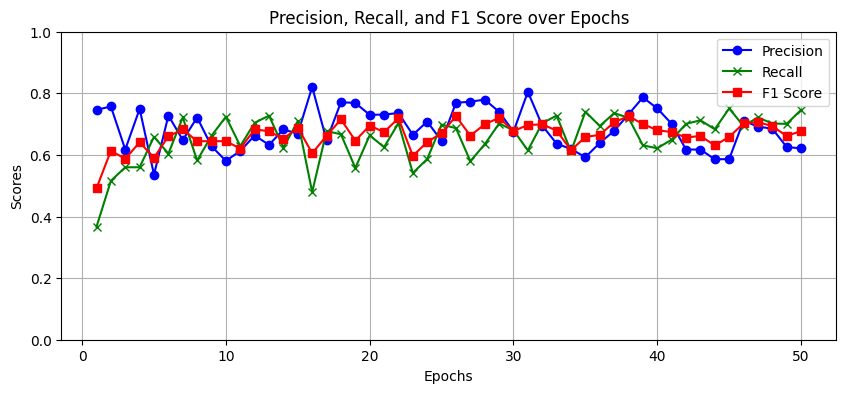

In [7]:
class MetricsPlotter:
    """
    A class for reading and plotting metrics from a log file generated during training.

    Args:
        file_path (str): The path to the log file containing training metrics.

    Attributes:
        file_path (str): The path to the log file.
        epochs (list): A list to store the epoch numbers.
        precisions (list): A list to store precision values.
        recalls (list): A list to store recall values.
        f1_scores (list): A list to store F1 scores.

    Methods:
        extract_metrics():
            Extract metrics (epoch, precision, recall, and F1 score) from the log file and store them in respective lists.

        plot_metrics():
            Plot the extracted precision, recall, and F1 score over epochs.

    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.epochs = []
        self.precisions = []
        self.recalls = []
        self.f1_scores = []

    def extract_metrics(self):
        """
        Extract metrics (epoch, precision, recall, and F1 score) from the log file and store them in respective lists.
        """
        
        pattern = re.compile(r'Epoch (\d+) .+?Valid_Precision@0\.50: ([0-9.]+)\tValid_Recall@0\.50: ([0-9.]+)\tValid_mAP@0\.50: [0-9.]+\tValid_F1@0\.50: ([0-9.]+)')
        with open(self.file_path, 'r') as file:
            content = file.readlines()

        for line in content:
            match = pattern.search(line)
            if match:
                epoch, precision, recall, f1_score = match.groups()
                self.epochs.append(int(epoch))
                self.precisions.append(float(precision))
                self.recalls.append(float(recall))
                self.f1_scores.append(float(f1_score))

    def plot_metrics(self):
        """
        Plot the extracted precision, recall, and F1 score over epochs.
        """
        
        plt.figure(figsize=(10, 4))

        plt.plot(self.epochs, self.precisions, label='Precision', color='blue', marker='o')
        plt.plot(self.epochs, self.recalls, label='Recall', color='green', marker='x')
        plt.plot(self.epochs, self.f1_scores, label='F1 Score', color='red', marker='s')

        plt.xlabel('Epochs')
        plt.ylabel('Scores')
        plt.title('Precision, Recall, and F1 Score over Epochs')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1)

        plt.show()

# Replace with path to your experiment log file
plotter = MetricsPlotter('vehicle-detection-checkpoints/detection/RUN_20231230_124449_544688/experiment_logs_Dec30_12_44_49.txt')
plotter.extract_metrics()
plotter.plot_metrics()

- **Precision**: The precision metric seems to fluctuate significantly throughout the training process. It starts off at a high value, suggesting that the model had a good initial ability to label a positive class correctly. However, it shows instability with many ups and downs, which might indicate that the model's performance in identifying true positives over the false positives varied widely from epoch to epoch.

- **Recall**: The recall metric also exhibits fluctuation but maintains a more consistent performance compared to precision. This metric starts a little lower than precision, increases, and then enters a phase of oscillation, which could suggest that the model's ability to find all relevant instances within the data varies as the training progresses. The recall seems less volatile than precision, which could mean that the balance between finding true positives and avoiding false negatives is more stable.

- **F1 Score**: The F1 Score is the harmonic mean of precision and recall and is used to measure a test’s accuracy. The F1 score combines both precision and recall into a single metric, which accounts for both false positives and false negatives. The F1 Score in this graph also fluctuates but generally trends above the 0.6 line, suggesting that the overall accuracy of the model is reasonable. The F1 Score seems to reflect the variance in both precision and recall, as it should.

Overall, the graph indicates that the model is experiencing some variance in its ability to correctly classify the positive class across epochs. The variations in precision, recall, and F1 Score suggest that the model might benefit from further tuning. 